## Image Classification with Convolutional Neural Networks (CNN)

Data: [CMU Face Images](https://archive.ics.uci.edu/static/public/124/cmu+face+images.zip)
<br>
By: [Toluwalashe Ogunleye](https://github.com/Toluwaa-o)

In [135]:
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import models, layers

### Random Seed
Set random seed to ensure reproducibility of random processes in your code.

In [136]:
random.seed(0)

### Image Directory

Save the path to the directory that stores all the image folders

In [36]:
faces_path = r"C:\Users\Owner\OneDrive\Desktop\Data Science\faces"

- Next, we create an empty list to hold all the folders that contain images.
- After that, we iterate over the directory we previously created and store all the folder paths in the list.

In [42]:
faces = []

for files in os.listdir(faces_path)[2:-1]:
    faces.append('./{}'.format(files))

- Next, we create a function to read all the .PGM files in a folder (Only the first 50 so we can optimize performance)
- This function also resizes any image with a reslution lower than 60x60 pixels
- This function returns a list containing each image and its corresponding label

In [107]:
def read_pgm(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        with open(img_path, 'rb') as f:
            magic_number = f.readline().decode().strip()
            if magic_number not in ['P2', 'P5']:
                raise ValueError('Not a valid PGM file.')
            width, height = map(int, f.readline().decode().split())
            max_gray_value = int(f.readline().decode())
            image_data = f.read()
        img = Image.frombytes('L', (width, height), image_data)
        img_array = np.array(img)
        if len(images) < 50 and filename.split('_')[-1][0].isdigit():
            label = filename.split('_')[0]
            if width < 60 and height < 60:
                img_array = resize(img_array, (60, 64))
            images.append((img_array, label))
    return images

- Next, we iterate over our list of face paths and call the funtion on each path
- The result of each function is added to our all_images array

In [108]:
all_images = []

for face in faces:
    all_images += read_pgm(face)

- Next, we check the length and the shape of our values

In [110]:
len(all_images), all_images[0][0].shape

(1000, (60, 64))

- Next, we shuffle the array so that our training, validation and test data is random.

In [111]:
np.random.shuffle(all_images)

- Next, we display the first 15 images in the array.

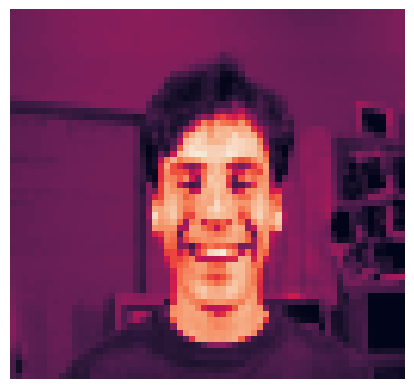

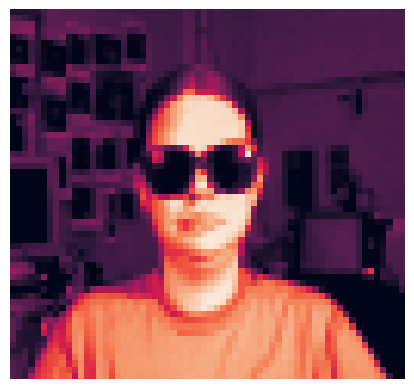

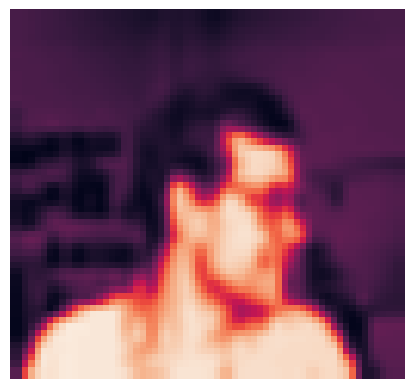

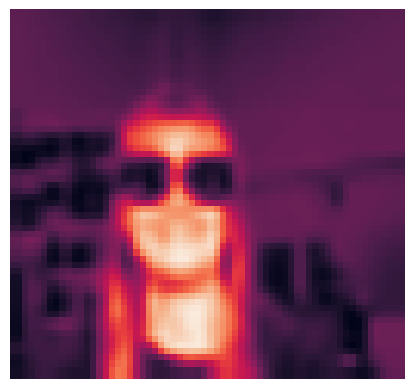

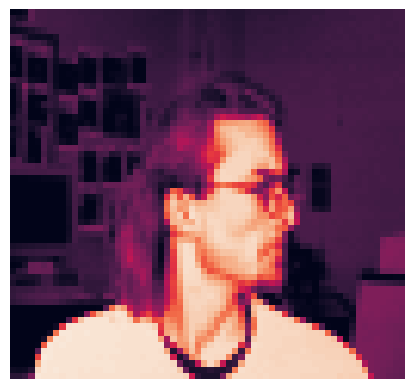

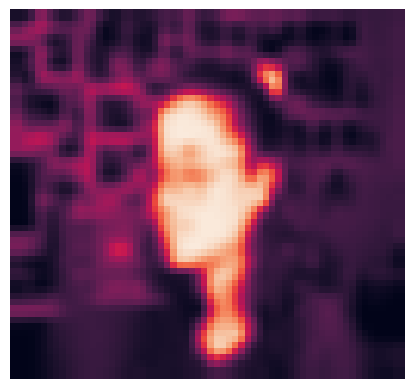

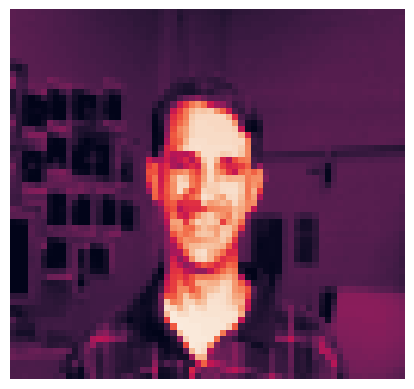

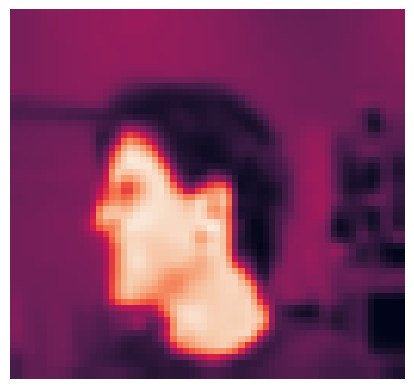

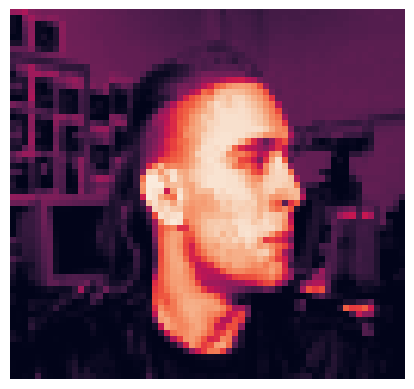

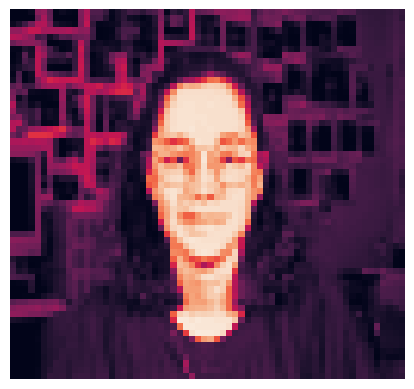

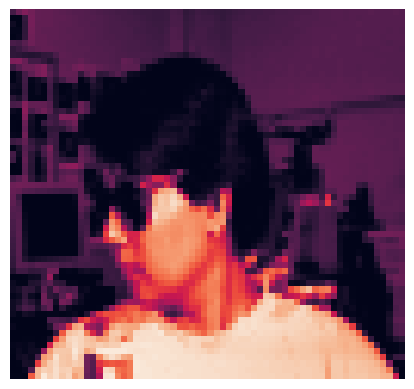

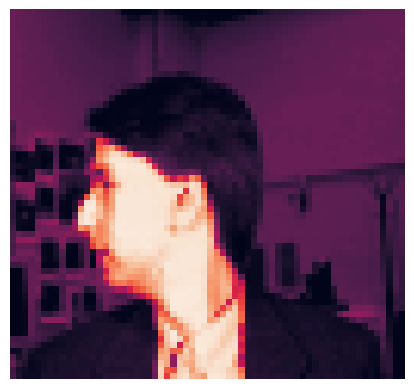

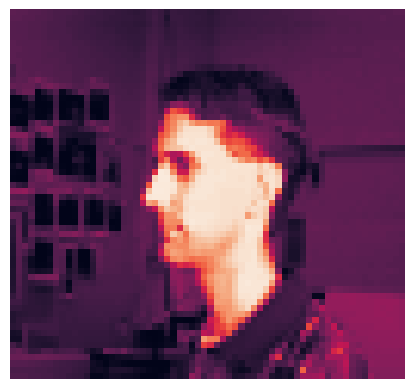

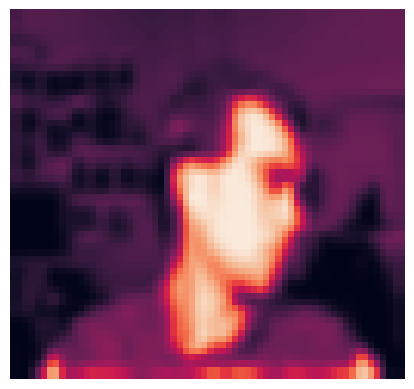

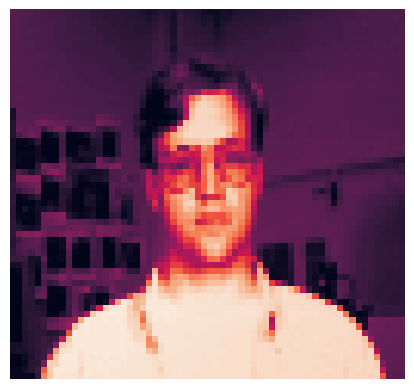

In [112]:
for f in all_images[0:15]:
    plt.imshow(f[0])
    plt.axis('off')
    plt.show()

- Next, we sort the values into targets and inputs

In [113]:
inputs = [arr[0] for arr in all_images]
target = [arr[1] for arr in all_images]

- The Conv2D layer expects input data with a minimum of 4 dimensions (batch size, height, width, channels)
- Since we are working with Grayscale values, we are have to add an extra dimension

In [129]:
inputs = np.expand_dims(inputs, axis=-1)

- Next, we encode the target variables because they were stored as categorical variables initially.

In [114]:
enc = LabelEncoder()

target = enc.fit_transform(target)

We have 20 Classes in the data set.

In [115]:
enc.classes_

array(['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon',
       'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak',
       'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo'],
      dtype='<U8')

### Sorting the data into training, validation and test

- First, we get the total number of rows of data we have.
- Next, we split that number so we have an 80-10-10 split
- Then we store that percentage in variables that represent inputs and target, for all three splits.

In [116]:
num_of_images = len(all_images)

In [117]:
train_num = int(0.8 * num_of_images)
valid_num = int(0.1 * num_of_images)
test_num = num_of_images - train_num - valid_num

In [118]:
train_num, valid_num, test_num

(800, 100, 100)

In [130]:
train_inputs = inputs[:train_num]
train_target = target[:train_num]

valid_inputs = inputs[train_num:train_num+valid_num]
valid_target = target[train_num:train_num+valid_num]

test_inputs = inputs[train_num+valid_num:]
test_target = target[train_num+valid_num:]

In [131]:
len(train_inputs), test_inputs[0].shape

(800, (60, 64, 1))

### Saving Data in a format that TensorFlow uses

- After sorting it, we store the training, validation and test data in npz format
- Then we retrive them and now, we can use them for our model.

In [132]:
np.savez('train', inputs=train_inputs, target=train_target)
np.savez('valid', inputs=valid_inputs, target=valid_target)
np.savez('test', inputs=test_inputs, target=test_target)

In [133]:
npz = np.load('train.npz')
train_x = npz['inputs']
train_y = npz['target']

npz = np.load('valid.npz')
valid_x = npz['inputs']
valid_y = npz['target']

npz = np.load('test.npz')
test_x = npz['inputs']
test_y = npz['target']

### Next, we create our model

- First, we outline the layers of the model.
- First, we rescale our model to contain 0-1 values
- The model has 2 convolution layers, immediately followed by 2 Maxpooling layers
- Each convolution layer has a 4 by 4 filter
- The activation function used after the convolution layers is the relu function.
- Each maxpooling layer uses a pooling window of (2,2)
- After those layers, we flatten the input and pass it into a dense layer with 50 units with relu activation.
- Then we have our output layer with an output size of 20 for each label class.

- After that, we compile the model.
- The learning rate for the model is 0.01, stored in the lr variable.
- The optimizer used is the Adam optimizer and we provide the learning rate as an argument.
- We use the Sparse Categorical Cross Entropy as our loss because our labels are not one hot encoded but they are integers from 0-19.
- We also use the accuracy metric because this is a classification problem.

- We set our number of epochs as 25
- verbose as 2 because we want the machine to print out information while it is learning
- We fit the model on our train_x and train_y data and validate it with our validation_data

In [143]:
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (4,4), activation='relu', input_shape=(60, 64, 1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(16, (4,4), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(20))

lr = 0.01

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 25

model.fit(
    train_x, train_y,
    epochs = epochs,
    validation_data = (valid_x, valid_y),
    verbose = 2
)

Epoch 1/25
25/25 - 4s - 171ms/step - accuracy: 0.0300 - loss: 3.0049 - val_accuracy: 0.0300 - val_loss: 2.9971
Epoch 2/25
25/25 - 1s - 36ms/step - accuracy: 0.0688 - loss: 2.9563 - val_accuracy: 0.1600 - val_loss: 2.8043
Epoch 3/25
25/25 - 1s - 37ms/step - accuracy: 0.3250 - loss: 2.1761 - val_accuracy: 0.4300 - val_loss: 1.5108
Epoch 4/25
25/25 - 1s - 40ms/step - accuracy: 0.5437 - loss: 1.5443 - val_accuracy: 0.5400 - val_loss: 1.3190
Epoch 5/25
25/25 - 1s - 40ms/step - accuracy: 0.5638 - loss: 1.4481 - val_accuracy: 0.5700 - val_loss: 1.3488
Epoch 6/25
25/25 - 1s - 38ms/step - accuracy: 0.6062 - loss: 1.4213 - val_accuracy: 0.5100 - val_loss: 1.6116
Epoch 7/25
25/25 - 1s - 57ms/step - accuracy: 0.6737 - loss: 1.4042 - val_accuracy: 0.7400 - val_loss: 1.9654
Epoch 8/25
25/25 - 1s - 49ms/step - accuracy: 0.6438 - loss: 1.5574 - val_accuracy: 0.5200 - val_loss: 1.3099
Epoch 9/25
25/25 - 1s - 37ms/step - accuracy: 0.6862 - loss: 1.4140 - val_accuracy: 0.5600 - val_loss: 1.1883
Epoch 10/

### Results

- After 25 epochs, we had a training accuracy of 99.37%, coupled with a loss of 0.11.
- On the validation data, we had an accuracy of 97% and a loss of 1

In [149]:
loss, accuracy = model.evaluate(test_x, test_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9868 - loss: 0.1646


### Testing

- Next, we evaluate the model's performance with out test data and the model produced a result of 98.7%
- This concludes this CNN project.